# Setup

In [1]:
# Setup Tensorflow

import tensorflow as tf
gpus = tf.config.list_physical_devices(device_type='GPU')
for gpu in gpus:
    try:
        tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
# Setup Local Libs

import sys
sys.path.append("../src/")

from utils import *
from training import *
from data_generators import *
from model_builders import *

In [3]:
# Imports

from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import load_model, Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2

In [4]:
# Set best models and images filepaths

bbox_model_filepath = "../experiments/results/tops_augmented/regular/imgsize-224_convblocks-4_basefilters-16_densesize-1024/best_model.h5"
bbox_separable_model_filepath = "../experiments/results/tops_augmented/separable/imgsize-112_convblocks-3_basefilters-16_densesize-1024/best_model.h5"
triplet_extractor_model_filepath = "../experiments/results/triplet_base/dist-eucl/best_model.h5"
triplet_extractor_distances_filepath = "../experiments/results/triplet_base/dist-eucl/distances.csv"
sample_imgs = ["../sample_imgs/raw/000041.jpg", "../sample_imgs/raw/000050.jpg", "../sample_imgs/raw/000002.jpg", "../sample_imgs/raw/000093.jpg"]

# Segmentation Demonstration

## Regular CNN Segmentation

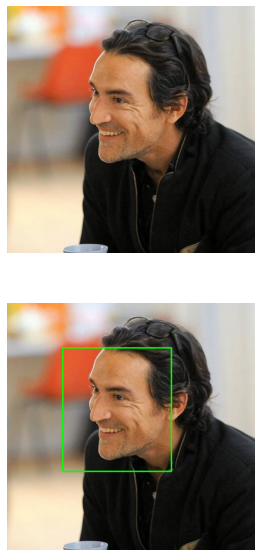

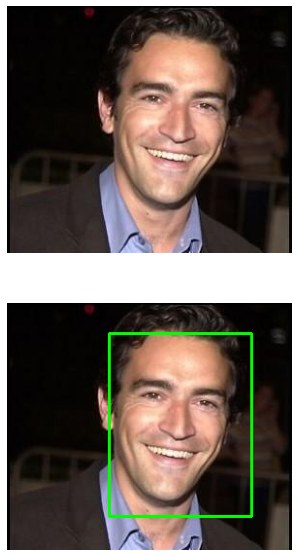

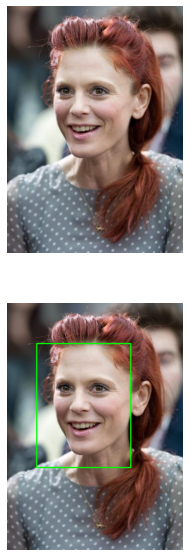

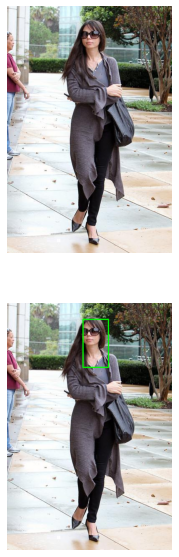

In [5]:
model = load_model(bbox_model_filepath, compile=False)

for img_file in sample_imgs:
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    for ax in axs:
        ax.axis('off')

    img = cv2.imread(img_file)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    aux_img = cv2.cvtColor(cv2.resize(np.copy(img), (224, 224), interpolation=cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB)
    aux_img = (aux_img/255.0)[np.newaxis, :, :, :]
    bbox = model.predict(aux_img)[0]
    bbox[[0, 2]] *= float(img.shape[1])
    bbox[[1, 3]] *= float(img.shape[0])
    bbox = np.around(bbox).astype(np.int32)
    cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), (0, 255, 0), 2)
    axs[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

del model
tf.keras.backend.clear_session()

## Depthwise Separable CNN Segmentation

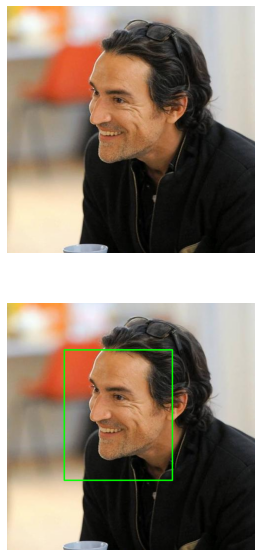

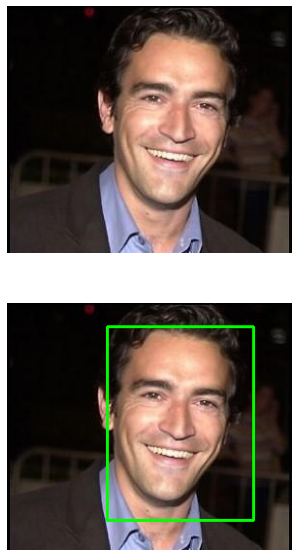

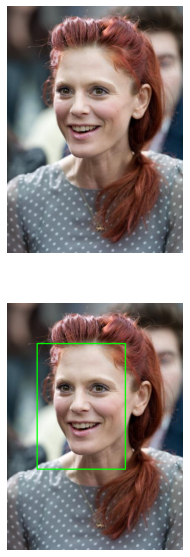

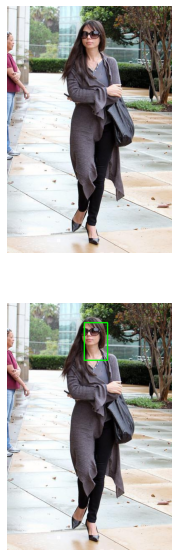

In [6]:
model = load_model(bbox_separable_model_filepath, compile=False)

comp_faces = []
for img_file in sample_imgs:
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))
    for ax in axs:
        ax.axis('off')

    img = cv2.imread(img_file)
    axs[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

    aux_img = cv2.cvtColor(cv2.resize(np.copy(img), (112, 112), interpolation=cv2.INTER_LINEAR), cv2.COLOR_BGR2RGB)
    aux_img = (aux_img/255.0)[np.newaxis, :, :, :]
    bbox = model.predict(aux_img)[0]
    bbox[[0, 2]] *= float(img.shape[1])
    bbox[[1, 3]] *= float(img.shape[0])
    bbox = np.around(bbox).astype(np.int32)
    comp_faces += [np.copy(img[bbox[1]:bbox[3], bbox[0]:bbox[2]])]
    cv2.rectangle(img, tuple(bbox[:2]), tuple(bbox[2:]), (0, 255, 0), 2)
    axs[1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

del model
tf.keras.backend.clear_session()

# Verification Demonstration

## Image Pairs to be Used - From Depthwise Separable CNN's Segmentation

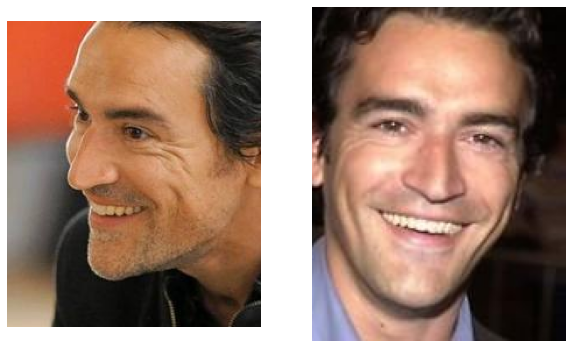

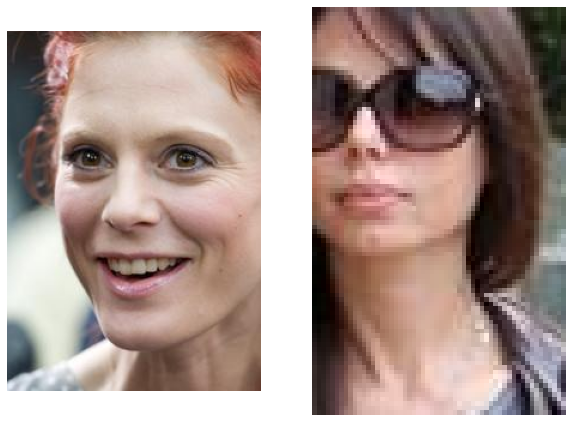

In [7]:
aux_comp_faces = [[comp_faces[0], comp_faces[1]], [comp_faces[2], comp_faces[3]]]
for pair in aux_comp_faces:
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))
    axs[0].axis('off')
    axs[1].axis('off')
    axs[0].imshow(cv2.cvtColor(pair[0], cv2.COLOR_BGR2RGB))
    axs[1].imshow(cv2.cvtColor(pair[1], cv2.COLOR_BGR2RGB))
    plt.show()
    print("\n\n\n\n\n\n")

## Using Triplet Trained CNN to Verify

In [8]:
# Restructing and preprocessing data for the CNN

comp_faces = [cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR) for img in comp_faces]
comp_faces = [vgg16.preprocess_input(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) for img in comp_faces]
comp_faces = [np.stack([comp_faces[0], comp_faces[2]]), np.stack([comp_faces[1], comp_faces[3]])]

In [9]:
# Setting the distance threshold
verf_thresh = pd.read_csv(triplet_extractor_distances_filepath)
verf_thresh = verf_thresh.loc[verf_thresh["Set"] == "Train"]
verf_thresh = float((verf_thresh["Pos Dist Mean"] + verf_thresh["Neg Dist Mean"]) / 2.0)

# Building the verification model
model = load_model(triplet_extractor_model_filepath, compile=False, custom_objects={'L2Normalization':L2Normalization})
model = build_triplet_classifier_model(model, dist_type='eucl', threshold=verf_thresh)

# Predicting
preds = model.predict(comp_faces)
print("Pair 1 -> {}".format("Same Person" if preds[0] else "Different People"))
print("Pair 2 -> {}".format("Same Person" if preds[1] else "Different People"))

Pair 1 -> Same Person
Pair 2 -> Different People
